# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-p43xjtja
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-p43xjtja
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=c7ddd083e393c4d30340b35ee509061df25f3983edd88d2408296bf17efee72f
  Stored in directory: /tmp/pip-ephem-wheel-cache-zv35hswx/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 1.13.1+cu116


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 200MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f94e30e78b0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

1.png
2.png
3.png
4.png
5.png
6.png
7.png
8.png
9.png
10.png
11.png
12.png
13.png
14.png
15.png
16.png
17.png
18.png
19.png
20.png
21.png
22.png
23.png
24.png
25.png
26.png
27.png
28.png
29.png
30.png
31.png
32.png
33.png
34.png
35.png
36.png
37.png
38.png
39.png
40.png
41.png
42.png
43.png
44.png
45.png
46.png
47.png
48.png
49.png
50.png


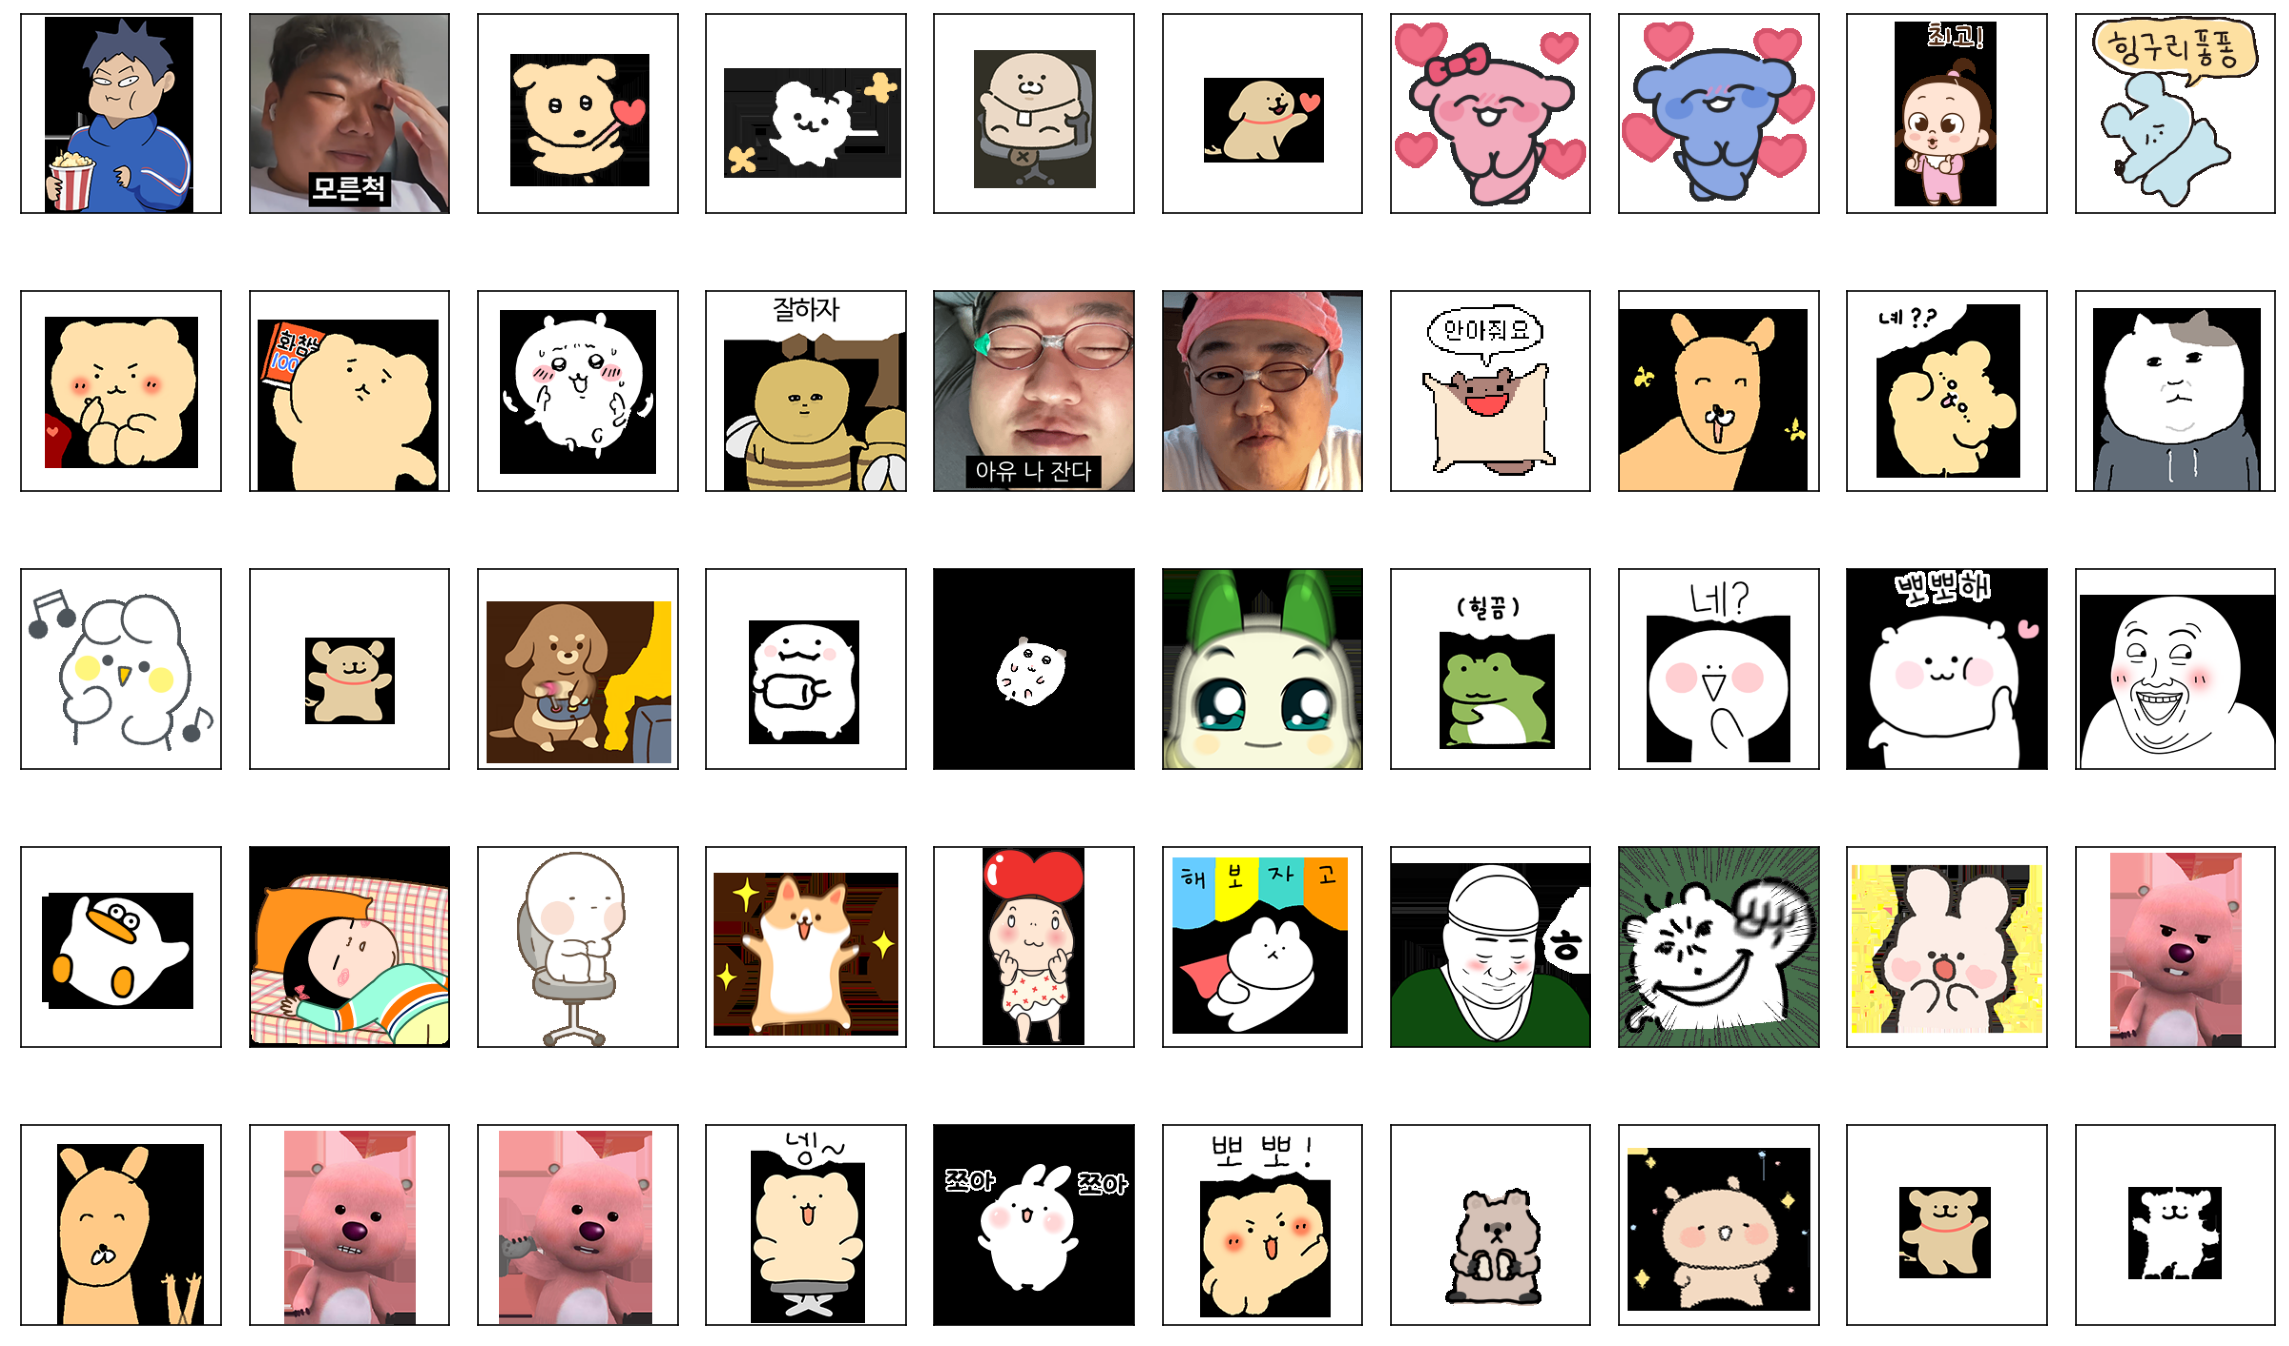

In [ ]:
original_images = []
images = []
#texts = []
plt.figure(figsize=(16, 10))
a = os.listdir("/content/drive/MyDrive/data/thumnails/thum")

for filename in [filename for filename in sorted(a, key=lambda x: int(x.split('.')[0]))]:
    image = Image.open(os.path.join("/content/drive/MyDrive/data/thumnails/thum", filename)).convert("RGB")
  
    plt.subplot(5, 10, len(images) + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    #texts.append(descriptions[name])

plt.tight_layout()


In [ ]:
test_original_images = []
test_images = []

for filename in [filename for filename in os.listdir("/content/drive/MyDrive/data/test") if filename.endswith(".png") or filename.endswith(".jpg")] :
    image = Image.open(os.path.join("/content/drive/MyDrive/data/test", filename)).convert("RGB")
    test_original_images.append(image)
    test_images.append(preprocess(image))

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

In [ ]:
test_image_input = torch.tensor(np.stack(test_images)).cuda()

with torch.no_grad():
    test_image_features = model.encode_image(test_image_input).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
similarity = test_image_features.cpu().numpy() @ image_features.cpu().numpy().T

In [ ]:
print(similarity.shape)
similarity

(2, 50)


array([[ 7.51493  ,  7.29982  ,  9.909006 ,  8.83649  ,  8.62628  ,
         9.235199 ,  9.454173 ,  9.072961 ,  7.970193 ,  7.987939 ,
         9.3545475,  8.724583 ,  8.47751  ,  7.396436 ,  6.7824516,
         6.6532664,  8.126785 ,  8.756063 ,  8.282181 ,  8.82899  ,
         7.7650757,  9.045185 ,  8.345427 ,  9.0494585,  7.6577897,
         8.846326 ,  7.8597007,  8.20055  ,  8.48053  ,  7.924024 ,
         8.256013 ,  7.315765 ,  8.311544 ,  8.792425 ,  8.569131 ,
         7.526581 ,  8.005422 ,  8.660555 ,  9.551951 , 10.205273 ,
         8.578901 , 10.28488  , 10.327136 ,  8.321099 ,  7.9150963,
         8.60169  ,  9.163658 ,  8.802665 ,  8.888323 ,  8.225356 ],
       [ 6.6811585,  7.6039553,  7.3158016,  7.102088 ,  7.4695535,
         7.4378324,  7.425914 ,  7.032787 ,  7.680835 ,  7.3572373,
         7.657989 ,  7.465015 ,  7.6376934,  6.9517107,  8.162323 ,
         8.194425 ,  6.821357 ,  7.6617875,  7.632385 ,  6.8960905,
         6.5792265,  7.2231545,  6.7692385,  7.

In [ ]:
count = 50 

plt.figure(figsize=(20, 10),dpi=500)
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
#plt.yticks(range(count), images, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower") # extent=(i - 0.5, i + 0.5, -1.6, -0.6)
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=2)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(True)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between image features", size=20)

Text(0.5, 1.0, 'Cosine similarity between image features')

In [ ]:
# emoticon name
thumnails_name = ["가비지타임 작뿡티콘", "곽튜브 짤 종합선물세트", "깜자라고해", "꼬물꼬물 따랑해 2 (곰식이 ver)", "꾸버는 열일중","나는야 시고르 리트리버", "댕잘어울리는 댕댕이 (분댕이 ver)",
 "댕잘어울리는 댕댕이 (파댕이 ver)","똥꼬발랄 쪼꼬미 쥐방울", "말투왜그래인터넷많이하는사람같아", "망그러진 곰 5", "망그러진 곰 6", "먼작귀2탄~먼가작고귀여운녀석~(치이카와)","묵직한 곤충들", "문상훈 짤 모음","문상훈 짤 모음 2","바들바들 동물콘","GO라니","베고미의 사회생활",
         "빈티지 고양이 3",
        "사랑토끼는 사랑가득 열애중",
         "시고르 리트리버 댕댕라이프",
        "아주 급하개 아주 바쁘개",
        "안녕! 나는 익명이고 쪼금 쭈글해",
      "암어 깜쥑한 쥑쥑",
        "양파쿵야의 줏대 있는 하루",
 "어딜봐도 개구리 깨꾹! 5", "업티콘 존댓말로 업업업!","여봉 오늘 더 사랑해", "오늘의 짤 #희노애짤","오둥이 입니다만 12", "옥철이의 사십춘기", "옴팡지게 기여어 옴팡이", "왕창 급하개 왕창 바쁘개", "요하의 예쁜말 대잔치",
    "유용한 긍정멘트 32톡",
   "으른의 삶 늬에시",
  "일상에 유익해요 커햄티콘!",
 "자신감 급상승 ! 냠냠이의 하루!",
 "잔망 루피","GO라니 2",
    "잔망 루피 4",
  "잔망 루피 5",
    "직장인인데요 2",
   "쪼랭이 찹쌀토끼 챱토",
    "커플 망그러진 곰",
    "쿼카임 4",
   "토뭉이는 꽁냥꽁냥",
  "해피 댕댕이 커플 (리트리버)",
 "해피 댕댕이 커플 (몰티즈)"]
 
print(len(thumnails_name))
 

50


In [ ]:
import heapq

for i in range(similarity.shape[0]):
  max_list = []
  thumnails_list = []
  similarity_list = similarity[i].reshape(-1).tolist()

  maxidx_list = heapq.nlargest(5, similarity_list)

  for k in maxidx_list:
    max_list.append(similarity_list.index(k))

  for j in max_list:
    thumnails_list.append(thumnails_name[j])
  print("추천", i+1, ":", thumnails_list)

추천 1 : ['잔망 루피 5', '잔망 루피 4', '잔망 루피', '깜자라고해', '자신감 급상승 ! 냠냠이의 하루!']
추천 2 : ['문상훈 짤 모음 2', '문상훈 짤 모음', '오늘의 짤 #희노애짤', '으른의 삶 늬에시', '옥철이의 사십춘기']
